### ANN from Scratch, using GPU

In [41]:
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

#### Steps to train and test the Model using the GPU
- Check for GPU Availability
- Move the Model to GPU
- Modify the training loop by moving the training data to GPU
- Modify the Evaluation loop by moving the training data to GPU

#### Check for GPU Availability

In [42]:
# Check fr GPU
device =torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [43]:
# torch.manual_seed(42)

In [44]:
df = pd.read_csv('data//fmnist_small.csv')
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,9,0,0,0,0,0,0,0,0,0,...,0,7,0,50,205,196,213,165,0,0
1,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,...,142,142,142,21,0,3,0,0,0,0
3,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8,0,0,0,0,0,0,0,0,0,...,213,203,174,151,188,10,0,0,0,0


In [45]:
df.shape

(6000, 785)

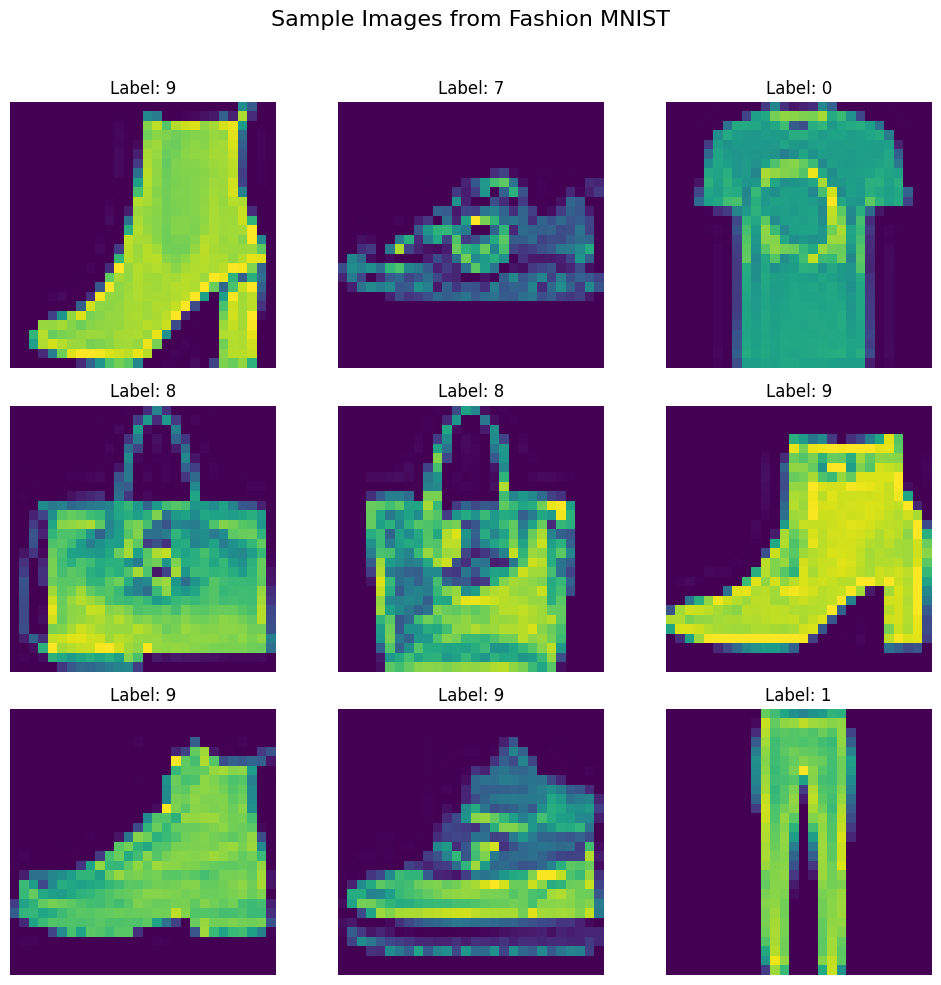

In [46]:
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
fig.suptitle('Sample Images from Fashion MNIST', fontsize=16)
for i, ax in enumerate(axes.flat):
    ax.imshow(df.iloc[i, 1:].values.reshape(28, 28))
    ax.set_title(f"Label: {df.iloc[i, 0]}")
    ax.axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [47]:
# train_test Split

X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [48]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4800, 784), (1200, 784), (4800,), (1200,))

In [49]:
# Scaling is done by dividing each pixel value in `X_train` and `X_test` by 255.0.
# Since the original pixel values range from 0 to 255, this operation transforms all values to the range [0, 1].
# This normalization helps neural networks train more efficiently by keeping input values within a consistent range.
X_train = X_train / 255.0
X_test = X_test / 255.0

#### Custom Dataset

In [50]:
# CustomDataset is a subclass of Dataset
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [51]:
# Load the dataset
train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_test, y_test)

len(train_dataset), len(test_dataset)

(4800, 1200)

#### Loading Data

In [52]:
# Create DataLoader objects for training and test datasets.
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

#### Define the Model

In [53]:
class SimpleANN(nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(num_features, 128),  # Input layer
            nn.ReLU(),              # Activation function
            nn.Linear(128, 64),     # Hidden layer
            nn.ReLU(),              # Activation function
            nn.Linear(64, 10)       # Output layer
        )

    def forward(self, X):
        return self.model(X)

In [54]:
learning_rate = 0.1
num_epochs = 100

In [55]:
model = SimpleANN(num_features=X_train.shape[1])
model = model.to(device)  # Move model to GPU if available

# Loss function
criterion = nn.CrossEntropyLoss()
# Optimizer
optimizer = optim.SGD(model.parameters(), lr=0.001)

In [56]:
for epoch in range(num_epochs):
    total_epoch_loss = 0
    for batch_features, batch_labels in train_loader:
        
        # Move batch data to GPU if available
        batch_features = batch_features.to(device)
        batch_labels = batch_labels.to(device)
        
        # forward pass
        y_pred = model(batch_features)

        # compute loss
        loss = criterion(y_pred, batch_labels)

        # backward pass
        optimizer.zero_grad()  # clear previous gradients
        loss.backward()

        # update weights
        optimizer.step()

        # accumulate loss
        # The loss.item() method retrieves the scalar value of the loss tensor.
        total_epoch_loss += loss.item()
    avg_loss = total_epoch_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

Epoch 1/100, Loss: 2.2943
Epoch 2/100, Loss: 2.2811
Epoch 3/100, Loss: 2.2676
Epoch 4/100, Loss: 2.2537
Epoch 5/100, Loss: 2.2394
Epoch 6/100, Loss: 2.2244
Epoch 7/100, Loss: 2.2082
Epoch 8/100, Loss: 2.1903
Epoch 9/100, Loss: 2.1705
Epoch 10/100, Loss: 2.1483
Epoch 11/100, Loss: 2.1238
Epoch 12/100, Loss: 2.0964
Epoch 13/100, Loss: 2.0657
Epoch 14/100, Loss: 2.0319
Epoch 15/100, Loss: 1.9946
Epoch 16/100, Loss: 1.9536
Epoch 17/100, Loss: 1.9089
Epoch 18/100, Loss: 1.8606
Epoch 19/100, Loss: 1.8094
Epoch 20/100, Loss: 1.7562
Epoch 21/100, Loss: 1.7021
Epoch 22/100, Loss: 1.6484
Epoch 23/100, Loss: 1.5959
Epoch 24/100, Loss: 1.5456
Epoch 25/100, Loss: 1.4980
Epoch 26/100, Loss: 1.4535
Epoch 27/100, Loss: 1.4123
Epoch 28/100, Loss: 1.3741
Epoch 29/100, Loss: 1.3390
Epoch 30/100, Loss: 1.3065
Epoch 31/100, Loss: 1.2763
Epoch 32/100, Loss: 1.2487
Epoch 33/100, Loss: 1.2226
Epoch 34/100, Loss: 1.1990
Epoch 35/100, Loss: 1.1764
Epoch 36/100, Loss: 1.1552
Epoch 37/100, Loss: 1.1357
Epoch 38/1

#### Model Eval

In [57]:
# set model to eval mode
model.eval()

SimpleANN(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [58]:
# Evaluation Code
total = 0 
correct = 0

# Evaluate model accuracy on test set using DataLoader
with torch.no_grad():
    for batch_features, batch_labels in test_loader:
        # Move batch data to GPU if available
        batch_features = batch_features.to(device)
        batch_labels = batch_labels.to(device)
        
        # Get model predictions for the batch
        y_pred = model(batch_features)
        # Get predicted class by taking the argmax
        predicted_class = torch.argmax(y_pred, dim=1) # Get the index of the maximum value in each row
        # Update total number of samples
        total += batch_labels.shape[0]
        # Update correct predictions count
        correct += (predicted_class == batch_labels).sum().item()
        
accuracy = correct / total
accuracy
print(correct, total, accuracy)

892 1200 0.7433333333333333


In [59]:
len(test_loader)

38